# Responsible Machine Learning for Ames, Iowa Housing Prices

### Before we start let's just check if user is in virtual environment.

In [1]:
import os
import sys
import warnings

class NotInVirutalEnv(UserWarning):
    pass

#This function compatible with Python 2 and 3 as well as Windows and Linux.
def inside_virtual():
    if os.getenv('VIRTUAL_ENV'):
        return True
    else:
        return False

if inside_virtual():
    print('You are inside a virtual environment, good to go.')
else:
    warnings.warn("You are outside a virtual environment, any new installs may affect other projects.", NotInVirutalEnv)

C:\Users\abhis\.conda\envs\hprml\lib\site-packages\ipykernel_launcher.py:18: NotInVirutalEnv: You are outside a virtual environment, any new installs may affect other projects.


More information on your system:

In [2]:
print(f'Path of the Virtual environment: {os.getenv("VIRTUAL_ENV")}')
print(f'Python Version: {sys.version}')
print(f'Your Python exe path: {sys.executable}')

Path of the Virtual environment: None
Python Version: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Your Python exe path: C:\Users\abhis\.conda\envs\hprml\python.exe


**It is advisable to create a new virtual environment so other projects are not affected.**

### Importing required libraries

In [3]:
SEED                    = 31415   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

In [4]:
# This is a line magic function in IPythonWith this backend, 
# the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
%matplotlib inline

# Importing Pandas 
import pandas as pd

# array, vector, matrix calculations
import numpy as np

# for sorting dictionaries
import operator

# for timers
import time

#Importing Seaborn for graphs
import seaborn as sns

# import h2o python bindings to h2o java server
import h2o

# simple module for training, explaining, and eval
from rmltk import explain, evaluate, model                        

# Importing Matplotlib
import matplotlib.pyplot as plt

### Setting common properties for the whole notebook

In [5]:
# start h2o with plenty of memory and threads
h2o.init(max_mem_size='10G', nthreads=4) 

# clears h2o memory
h2o.remove_all()                     
h2o.no_progress()  

# Suppressing Deprecation Warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# For ease of interpretation, limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# enable display of all columns in notebook
pd.options.display.max_columns = 999 

# Setting SNS properties so figures are well formed
sns.set(rc={'figure.figsize':(13.5,7.5)})
sns.set_context("talk")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from C:\Users\abhis\.conda\envs\hprml\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\abhis\AppData\Local\Temp\tmpb6up_i84
  JVM stdout: C:\Users\abhis\AppData\Local\Temp\tmpb6up_i84\h2o_abhis_started_from_python.out
  JVM stderr: C:\Users\abhis\AppData\Local\Temp\tmpb6up_i84\h2o_abhis_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,7 days and 57 minutes
H2O_cluster_name:,H2O_from_python_abhis_ag0yzs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.89 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


### Defining custom functions we would use throughtout the notebook

In [6]:
def are_there_nans(dataframe_or_ndarray):
    """This function accepts both DataFrame and ndarray type of object.
    Then return boolean value true if it contains nans or infinity.
    
    Args:
        dataframe_or_ndarray (DataFrame or ndarray): The object to be checked for presence of NaNs.
    
    Returns:
        status (bool): True if the passed object has nan values present anywhere.
    """
    if isinstance(dataframe_or_ndarray, pd.DataFrame):
        print("This is a Pandas Dataframe.")
        status = dataframe_or_ndarray.isnull().values.any()
        print("There are NaNs, you need to cleanup.") if status else print("No NaNs are present.")
        return status
    
    elif isinstance(dataframe_or_ndarray, pd.Series):
        print("This is a Pandas Series.")
        status = dataframe_or_ndarray.isnull().values.any()
        print("There are NaNs, you need to cleanup.") if status else print("No NaNs are present.")
        return status
    
    elif isinstance(dataframe_or_ndarray, np.ndarray):
        print("This is a Numpy array.")
        status = np.any(np.isnan(dataframe_or_ndarray))
        print("There are NaNs, you need to cleanup.") if status else print("No NaNs are present.")
        return status
    
    else:
        raise TypeError("A valid object was not passed. Expected DataFrame or ndarray object.")
    

### Reading our data into dataframes 

In [7]:
# Remember NA values in the datasets are set to NaNs which is good for us, since we can use inbuilt methods to deal with those.
# Additionally, na_values=None parameter will allow for other contents to be interpreted as NaNs  
# keep_default_na=True this parameter will keep NA like values (will not convert them to NaNs)

# Reading training dataset
homeprices_train = pd.read_csv("Data/train.csv")

# Reading testing dataset
homeprices_test = pd.read_csv("Data/test.csv")

#Save the 'Id' column
train_ID = homeprices_train['Id']
test_ID = homeprices_test['Id']

# Using inplace = True parameter so we don't need to reassign.
homeprices_train.drop("Id", axis = 1, inplace = True)
homeprices_test.drop("Id", axis = 1, inplace = True)

In [8]:
# Looking at first ten values of training dataset.
homeprices_train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.000,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.000,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,nan,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.000,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil,TA

In [9]:
# Looking at first ten values of testing dataset.
homeprices_test.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,60,RL,75.000,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,763.000,763.000,GasA,Gd,Y,SBrkr,763,892,0,1655,0.000,0.000,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.000,Fin,2.000,440.000,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,20,RL,nan,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.000,TA,Gd,PConc,Gd,TA,No,ALQ,935.000,Unf,0.000,233.000,1168.000,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.000,0.000,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.000,Fin,2.000,420.000,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,60,RL,63.000,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,789.000,789.000,GasA,Gd,Y,SBrkr,789,676,0,1465,0.000,0.000,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,393.000,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,20,RL,85.000,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,PConc,Gd,TA,Gd,GLQ,637.000,Unf,0.000,663.000,1300.000,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.000,0.000,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.000,Unf,2.000,506.000,TA,TA,Y,192,0,0,0,0

In [10]:
print("Training data column count: " +  str(homeprices_train.shape[1]) + " and Row count:" + str(homeprices_train.shape[0]))
print("Testing data column count: " + str(homeprices_test.shape[1]) + " and Row count:" + str(homeprices_test.shape[0]))

Training data column count: 80 and Row count:1460
Testing data column count: 79 and Row count:1459


###  Creating Id dataframe for submission later

In [11]:
# Selecting Id column from testing dataset
# homeprices_train_ids = homeprices_train[["Id"]]
# homeprices_test_ids = homeprices_test[["Id"]]

# Adding extra column for stacking later when we hot-encode 
homeprices_test['SalePrice'] = 0

### Initial data analysis

In [12]:
display(homeprices_train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.000,56.897,42.301,20.000,20.000,50.000,70.000,190.000
LotFrontage,1201.000,70.050,24.285,21.000,59.000,69.000,80.000,313.000
LotArea,1460.000,10516.828,9981.265,1300.000,7553.500,9478.500,11601.500,215245.000
OverallQual,1460.000,6.099,1.383,1.000,5.000,6.000,7.000,10.000
OverallCond,1460.000,5.575,1.113,1.000,5.000,5.000,6.000,9.000
YearBuilt,1460.000,1971.268,30.203,1872.000,1954.000,1973.000,2000.000,2010.000
YearRemodAdd,1460.000,1984.866,20.645,1950.000,1967.000,1994.000,2004.000,2010.000
MasVnrArea,1452.000,103.685,181.066,0.000,0.000,0.000,166.000,1600.000
BsmtFinSF1,1460.000,443.640,456.098,0.000,0.000,383.500,712.250,5644.000
BsmtFinSF2,1460.000,46.549,161.319,0.000,0.000,0.000,0.000,1474.000


In [13]:
display(homeprices_test.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.000,57.378,42.747,20.000,20.000,50.000,70.000,190.000
LotFrontage,1232.000,68.580,22.377,21.000,58.000,67.000,80.000,200.000
LotArea,1459.000,9819.161,4955.517,1470.000,7391.000,9399.000,11517.500,56600.000
OverallQual,1459.000,6.079,1.437,1.000,5.000,6.000,7.000,10.000
OverallCond,1459.000,5.554,1.114,1.000,5.000,5.000,6.000,9.000
YearBuilt,1459.000,1971.358,30.390,1879.000,1953.000,1973.000,2001.000,2010.000
YearRemodAdd,1459.000,1983.663,21.130,1950.000,1963.000,1992.000,2004.000,2010.000
MasVnrArea,1444.000,100.709,177.626,0.000,0.000,0.000,164.000,1290.000
BsmtFinSF1,1458.000,439.204,455.268,0.000,0.000,350.500,753.500,4010.000
BsmtFinSF2,1458.000,52.619,176.754,0.000,0.000,0.000,0.000,1526.000


### Missing data analysis

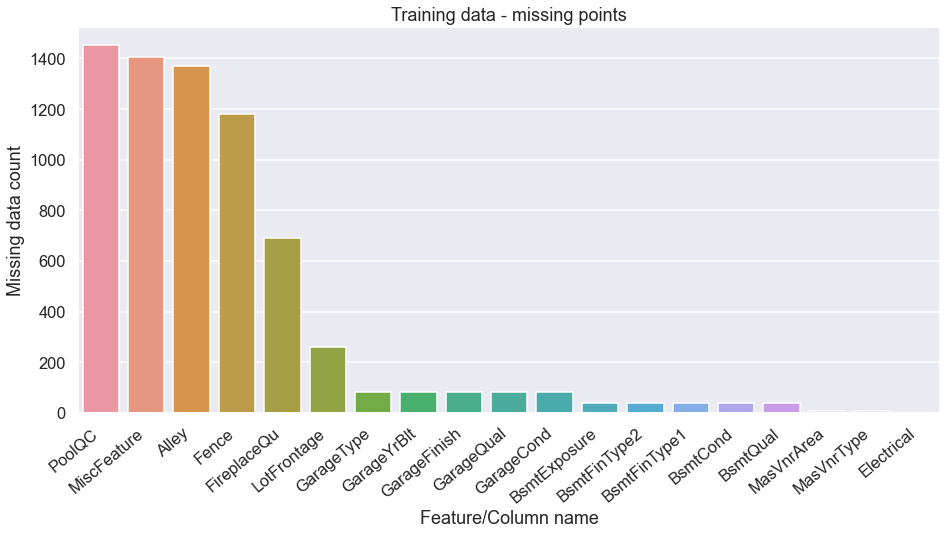

In [14]:
# Getting sum of NaNs over column axis.
homeprices_train_nan_count = homeprices_train.isnull().sum(axis = 0)

# Converting into dataframe
homeprices_train_nan_count = pd.DataFrame(homeprices_train_nan_count)

# Removing the ones which have associated zero count of NaNs
homeprices_train_nan_count2 = homeprices_train_nan_count.loc[(homeprices_train_nan_count != 0).all(axis=1), :]

# Sorting the values 
homeprices_train_nan_count2_sorted = homeprices_train_nan_count2.sort_values(homeprices_train_nan_count2.columns[0], ascending=False)

# Using sns barplot with x as index and y as the NaN count
ax = sns.barplot(x=homeprices_train_nan_count2_sorted.index, y=homeprices_train_nan_count2_sorted.columns[0], 
                 data=homeprices_train_nan_count2_sorted)

# Setting labels for x and y
ax.set(xlabel='Feature/Column name', ylabel='Missing data count')

# Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

# Setting up plot title
plt.title("Training data - missing points")

# Display all figures
plt.show()

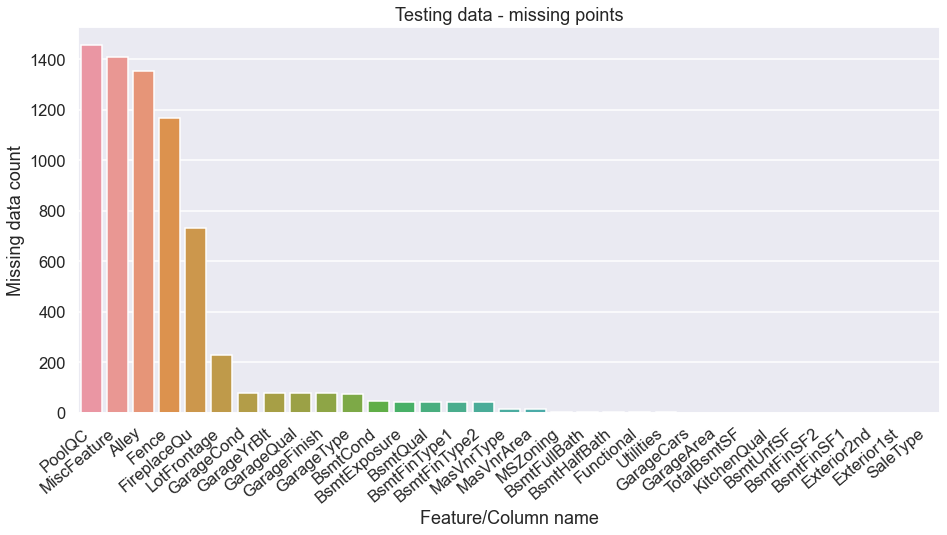

In [15]:
# Getting sum of NaNs over column axis.
homeprices_test_nan_count = homeprices_test.isnull().sum(axis = 0)

# Converting into dataframe
homeprices_test_nan_count = pd.DataFrame(homeprices_test_nan_count)

# Removing the ones which have associated zero count of NaNs
homeprices_test_nan_count2 = homeprices_test_nan_count.loc[(homeprices_test_nan_count != 0).all(axis=1), :]

# Sorting the values 
homeprices_test_nan_count2_sorted = homeprices_test_nan_count2.sort_values(homeprices_test_nan_count2.columns[0], ascending=False)

# Using sns barplot with x as index and y as the NaN count
ax = sns.barplot(x=homeprices_test_nan_count2_sorted.index, y=homeprices_test_nan_count2_sorted.columns[0], 
                 data=homeprices_test_nan_count2_sorted)

# Setting labels for x and y
ax.set(xlabel='Feature/Column name', ylabel='Missing data count')

# Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

# Setting up plot title
plt.title("Testing data - missing points")

# Display all figures
plt.show()

More about here - [Tight Layout](https://matplotlib.org/3.2.1/tutorials/intermediate/tight_layout_guide.html) 

### Imputing values - replacing NaNs with appropriate values

Before we delve into imputation of missing values, I want to highlight a book for dealing with missing values. [Statistical Analysis with Missing Data, Second Edition](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119013563). It is very easy to replace missing values with a single mean or median but they mislead the statistical result, hence we are using KNN imputation which makes the most sense here given the nature of the dataset. 

**We are NOT combining training and testing data, if we preprocess the data using any part of testing data, it ceases to be the testing dataset. They have to be processed separately.**

#### Dealing with top five columns with missing values 
- PoolQC (Pool quality) 
- MiscFeature (Miscellaneous feature not covered in other categories)
- Alley (Type of alley access to property) 
- Fence (Fence quality)
- FireplaceQu (Fireplace quality)

#### Training data

In [16]:
# Simple code for filling NaN

homeprices_train["PoolQC"] = homeprices_train["PoolQC"].fillna("NoPool")
homeprices_train["MiscFeature"] = homeprices_train["MiscFeature"].fillna("NoFeatures")
homeprices_train["Alley"] = homeprices_train["Alley"].fillna("NoAlley")
homeprices_train["Fence"] = homeprices_train["Fence"].fillna("NoFence")
homeprices_train["FireplaceQu"] = homeprices_train["FireplaceQu"].fillna("NoFireplace")

#--------------------------------------------------------------------------------------------#

# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.

# homeprices_train.fillna({column:"None" for column in ['PoolQC','MiscFeature','Alley','Fence', 'NoFireplace']}, inplace=True)

#### Testing data

In [17]:
# Simple code for filling NaN

homeprices_test["PoolQC"] = homeprices_test["PoolQC"].fillna("NoPool")
homeprices_test["MiscFeature"] = homeprices_test["MiscFeature"].fillna("NoFeatures")
homeprices_test["Alley"] = homeprices_test["Alley"].fillna("NoAlley")
homeprices_test["Fence"] = homeprices_test["Fence"].fillna("NoFence")
homeprices_test["FireplaceQu"] = homeprices_test["FireplaceQu"].fillna("NoFireplace")

#--------------------------------------------------------------------------------------------#

# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.

# homeprices_train.fillna({column:"None" for column in ['PoolQC','MiscFeature','Alley','Fence', 'NoFireplace']}, inplace=True)

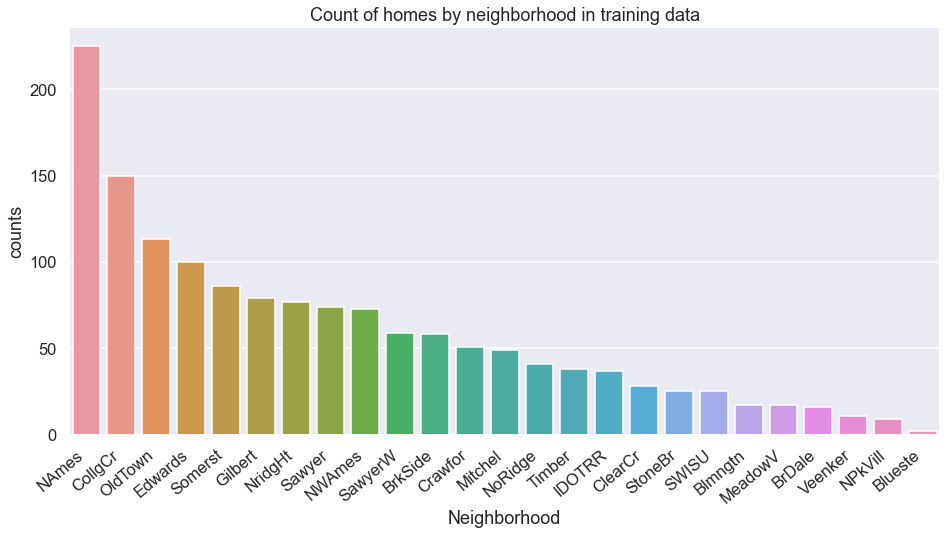

In [18]:
# Selecting Neighborhood then we are using group by with Neighborhood again then couting number of rows.
homeprices_train_neighbourhood_count = homeprices_train[["Neighborhood"]].groupby(["Neighborhood"]).\
                                    size().reset_index(name='counts').sort_values(['counts'], ascending=False)

# Creating ax object for SNS barplot
ax = sns.barplot(x=homeprices_train_neighbourhood_count.Neighborhood, y=homeprices_train_neighbourhood_count.counts, \
                 data = homeprices_train_neighbourhood_count)

# Rotating the labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight layout
plt.tight_layout()

# Setting plot title
plt.title("Count of homes by neighborhood in training data")

# Display all figures
plt.show()

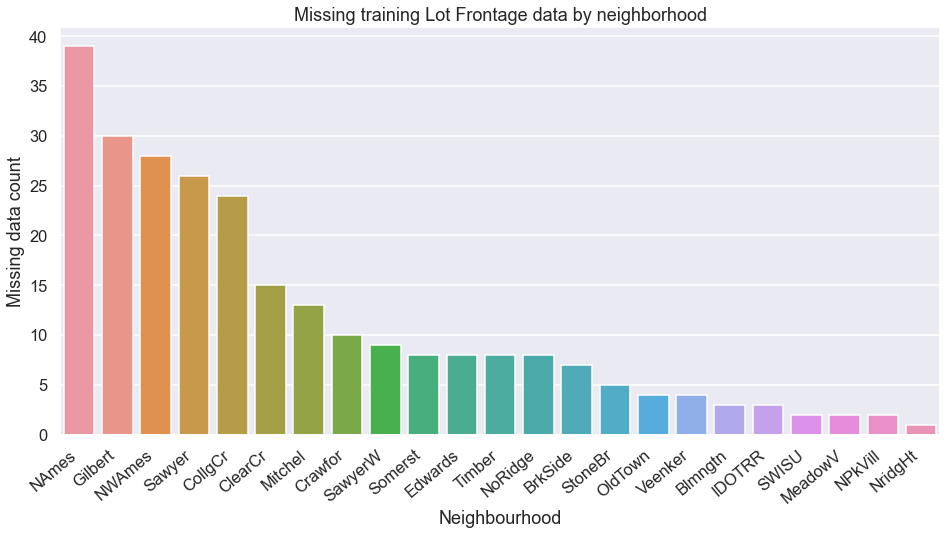

In [19]:
# Getting sum of NaNs over column axis.
homeprices_train_neighborhood_nan_count = homeprices_train.groupby("Neighborhood") \
                                                        .agg({'LotFrontage': lambda x: x.isnull().sum()})

# Converting into dataframe
homeprices_train_nan_count = pd.DataFrame(homeprices_train_neighborhood_nan_count)

# Removing the ones which have associated zero count of NaNs
homeprices_train_nan_count2 = homeprices_train_nan_count.loc[(homeprices_train_nan_count != 0).all(axis=1), :]

# Sorting the values 
homeprices_train_nan_count2_sorted = homeprices_train_nan_count2.sort_values(homeprices_train_nan_count2.columns[0], 
                                                                             ascending=False)

# Using sns barplot with x as index and y as the NaN count
ax = sns.barplot(x=homeprices_train_nan_count2_sorted.index, y=homeprices_train_nan_count2_sorted.columns[0], 
                 data=homeprices_train_nan_count2_sorted)

# Setting labels for x and y
ax.set(xlabel='Neighbourhood', ylabel='Missing data count')

# Rotating x labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

plt.title("Missing training Lot Frontage data by neighborhood")

plt.show()

### Before we impute the values of Lot Frontage let's get everything else sorted

In [20]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:"NoGarage" for column in 
                         ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']}, 
                        inplace=True)

homeprices_test.fillna({column:"NoGarage" for column in 
                         ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']}, 
                        inplace=True)

In [21]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:0 for column in 
                         ['GarageYrBlt', 'GarageArea', 'GarageCars']}, 
                        inplace=True)

homeprices_test.fillna({column:0 for column in 
                         ['GarageYrBlt', 'GarageArea', 'GarageCars']}, 
                        inplace=True)

In [22]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:0 for column in 
                         ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']}, 
                        inplace=True)

homeprices_test.fillna({column:0 for column in 
                         ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']}, 
                        inplace=True)

In [23]:
# One liner to fill all the NaNs in the listed columns with None.
# Using list comprehension here.
homeprices_train.fillna({column:"NoBsmt" for column in 
                         ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']}, 
                        inplace=True)

homeprices_test.fillna({column:"NoBsmt" for column in 
                         ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']}, 
                        inplace=True)

In [24]:
homeprices_train["MasVnrType"].fillna("None", inplace=True)
homeprices_train["MasVnrArea"].fillna(0, inplace=True)

homeprices_test["MasVnrType"].fillna("None", inplace=True)
homeprices_test["MasVnrArea"].fillna(0, inplace=True)

In [25]:
homeprices_train['MSZoning'].fillna(homeprices_train['MSZoning'].mode()[0], inplace=True)
homeprices_test['MSZoning'].fillna(homeprices_test['MSZoning'].mode()[0], inplace=True)

In [26]:
homeprices_train['Exterior1st'].fillna(homeprices_train['Exterior1st'].mode()[0], inplace=True)
homeprices_test['Exterior1st'].fillna(homeprices_test['Exterior1st'].mode()[0], inplace=True)
homeprices_train['Exterior2nd'].fillna(homeprices_train['Exterior2nd'].mode()[0], inplace=True)
homeprices_test['Exterior2nd'].fillna(homeprices_test['Exterior2nd'].mode()[0], inplace=True)

In [27]:
homeprices_train['SaleType'].fillna(homeprices_train['SaleType'].mode()[0], inplace=True)
homeprices_test['SaleType'].fillna(homeprices_test['SaleType'].mode()[0], inplace=True)

In [28]:
homeprices_train['MSSubClass'].fillna("None", inplace=True)
homeprices_test['MSSubClass'].fillna("None", inplace=True)

In [29]:
homeprices_train.drop("Utilities", axis = 1, inplace = True)
homeprices_test.drop("Utilities", axis = 1, inplace = True)

In [30]:
homeprices_train["Functional"].fillna("Typ", inplace=True)
homeprices_test["Functional"].fillna("Typ", inplace=True)

In [31]:
homeprices_train['Electrical'].fillna(homeprices_train['Electrical'].mode()[0], inplace=True)
homeprices_test['Electrical'].fillna(homeprices_test['Electrical'].mode()[0], inplace=True)

In [32]:
homeprices_train['KitchenQual'].fillna(homeprices_train['KitchenQual'].mode()[0], inplace=True)
homeprices_test['KitchenQual'].fillna(homeprices_test['KitchenQual'].mode()[0], inplace=True)

In [33]:
homeprices_train["LotFrontage"] = homeprices_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
homeprices_test["LotFrontage"] = homeprices_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

### Plotting strongest correlation to Sale Price

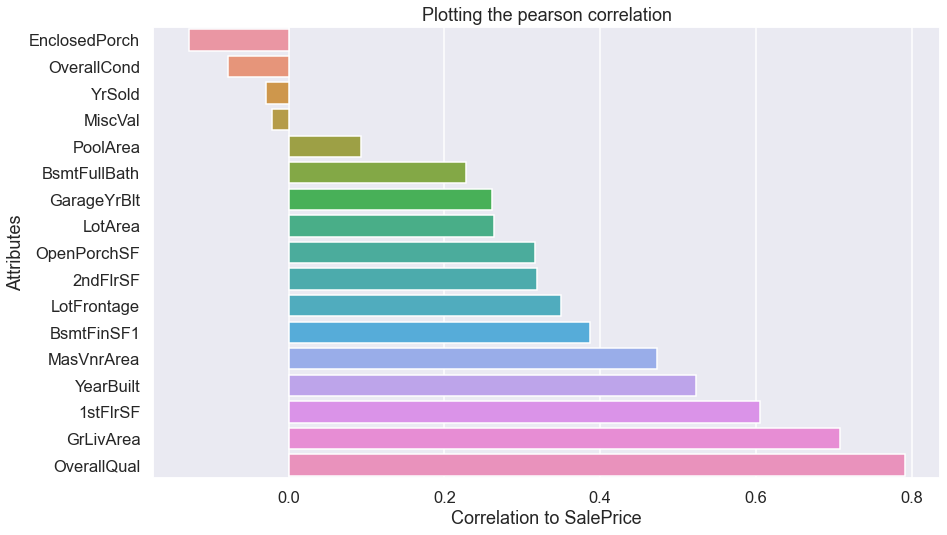

In [34]:
# Pearson correlation of whole matrix
corr_list = homeprices_train.corr().unstack().sort_values().drop_duplicates()

# Converting to dataframe
corr_list = pd.DataFrame(corr_list)

# Resetting multiindex to normal to columns so we can work easily
corr_list = corr_list.reset_index()

corr_to_dependent = corr_list[corr_list['level_1']=='SalePrice'].sort_values(corr_list.columns[2], ascending=True)

# Creating a bar plot
ax = sns.barplot(x=corr_to_dependent.columns[2],y=corr_to_dependent.level_0, data=corr_to_dependent, ci=0)

# Setting labels for x and y
ax.set(xlabel='Correlation to SalePrice', ylabel='Attributes')

# Using tight_layout which automatically adjusts subplot params so that 
# the subplot(s) fits in to the figure area.
plt.tight_layout()

# Setting up plot title
plt.title("Plotting the pearson correlation")

# Display all figures
plt.show()

Going a step further and calculating mean shapley values for features.

In [35]:
# Adding total sqfootage feature 
homeprices_train['WholeHouseSF'] = homeprices_train['TotalBsmtSF'] + homeprices_train['1stFlrSF'] + homeprices_train['2ndFlrSF']

# Adding total sqfootage feature 
homeprices_test['WholeHouseSF'] = homeprices_test['TotalBsmtSF'] + homeprices_test['1stFlrSF'] + homeprices_test['2ndFlrSF']

In [36]:
all_data = homeprices_train.append(homeprices_test)

In [37]:
all_data_dummy = pd.get_dummies(all_data)
print(all_data_dummy.shape)

(2919, 302)


In [38]:
homeprices_train_dummy = all_data_dummy[all_data_dummy.SalePrice != 0]

homeprices_test_dummy = all_data_dummy[all_data_dummy.SalePrice == 0]

In [39]:
homeprices_train_dummy_features = homeprices_train_dummy.loc[:, homeprices_train_dummy.columns != 'SalePrice']

homeprices_train_dummy_dependent = homeprices_train_dummy.loc[:, homeprices_test_dummy.columns == 'SalePrice']

homeprices_test_dummy_features = homeprices_test_dummy.loc[:, homeprices_test_dummy.columns != 'SalePrice']


## Removing outliers

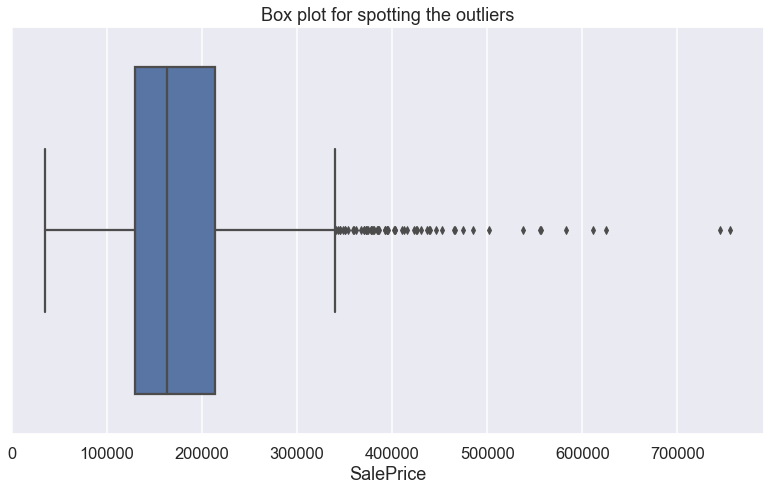

In [40]:
sns.boxplot(x=homeprices_train['SalePrice'])
plt.title("Box plot for spotting the outliers")
plt.show()

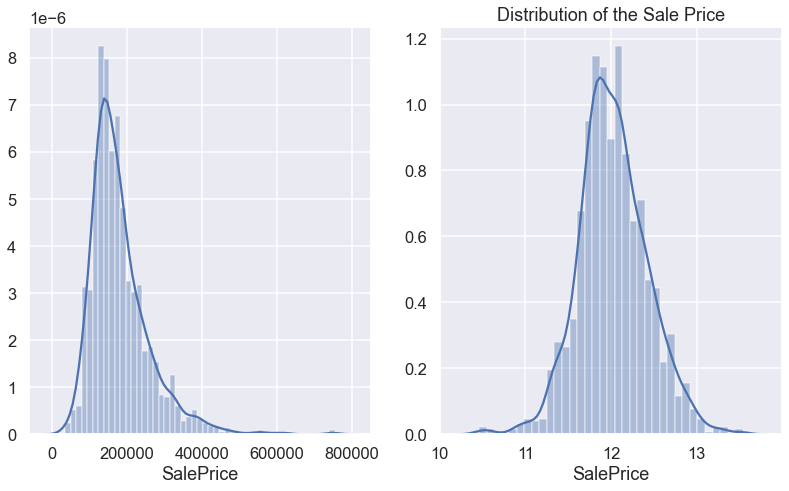

In [41]:
# Tuple unpacking returns the fig and axes objects as written below
# ax1 and ax2 refer to each cell in subplots argument
# i.e. plt.subplot(row,column), for example: row x column = number of objects returned
fig, (ax1,ax2) = plt.subplots(1, 2)

# Distribution plot for SalePrice
sns.distplot(homeprices_train['SalePrice'], ax=ax1)

# Distribution plot for log of SalePrice
sns.distplot(np.log(homeprices_train['SalePrice']), ax=ax2)

#
plt.title("Distribution of the Sale Price")

#
plt.show()

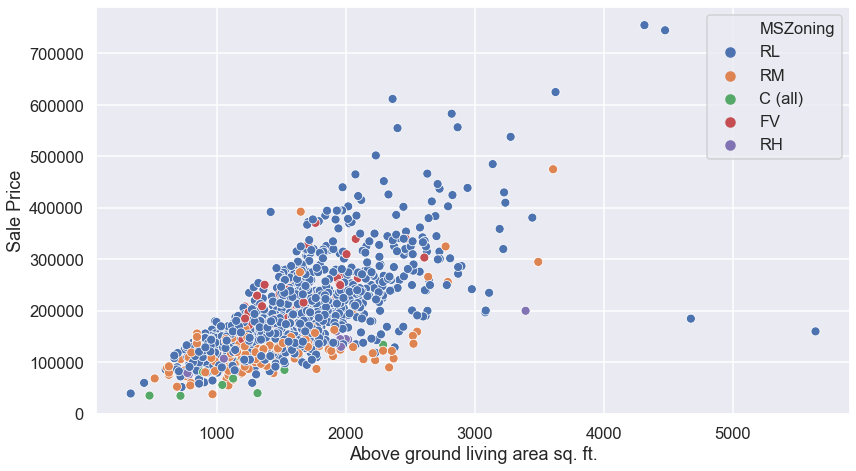

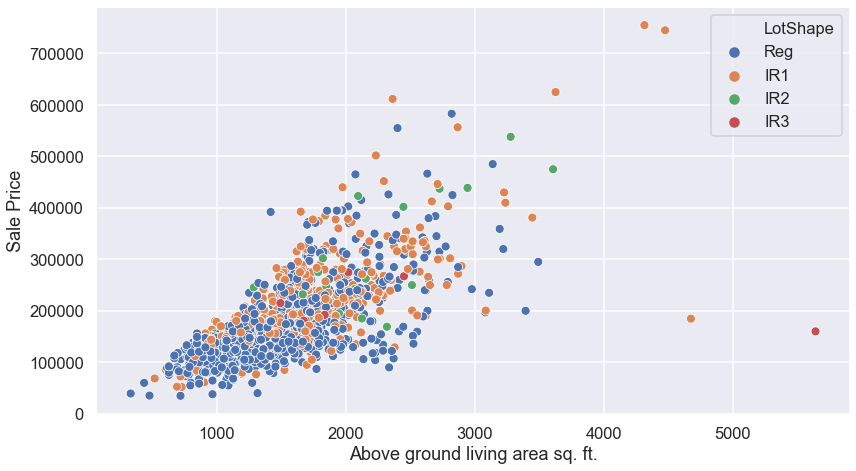

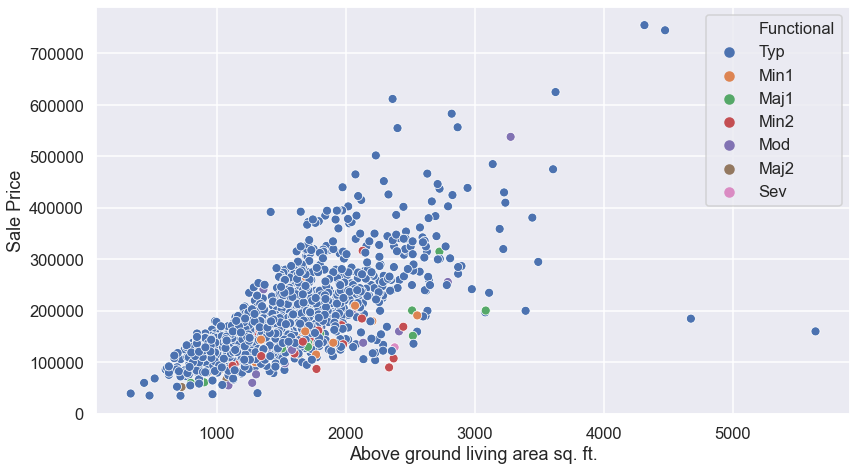

In [42]:
for colname in ["MSZoning", "LotShape", "Functional"]:
    # Using plt figure to intiate a new figure everytime we plot.
    # Else this would just create a combined figure which wouldn't make sense.
    plt.figure()
    
    # Using Seahorse scatterplot visualize a relationship between  
    ax = sns.scatterplot(x="GrLivArea", y="SalePrice", hue=colname, data=homeprices_train)
    
    # Setting label for x and y axes.
    ax.set(xlabel='Above ground living area sq. ft.', ylabel='Sale Price')

In [43]:
#Deleting outliers
homeprices_train = homeprices_train.drop(homeprices_train[(homeprices_train['GrLivArea']>4000) & (homeprices_train['SalePrice']<300000)].index)

## Splitting Data

In [44]:
# # Getting feature labels for h20 use

# Following is the complicated way to get column names without using .remove mathod
# X_labels = [col for col in (homeprices_train_dummy.loc[:, homeprices_train_dummy.columns != 'SalePrice']).columns]

# Setting y label
y_label = 'SalePrice'

# Creating a list of all column names of homeprices_train_dummy
X_labels = [col for col in homeprices_train_dummy.columns]

# Removing SalePrice from the X_labels.
X_labels.remove(y_label)

Split the training and valid into X and Y matrix so we can work.

In [45]:
from sklearn.model_selection import train_test_split

X_features = homeprices_train_dummy.loc[:, homeprices_train_dummy.columns != 'SalePrice']
y_saleprice = homeprices_train_dummy.loc[:, 'SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_saleprice, test_size = 0.3, random_state = 0)

train, valid = train_test_split(homeprices_train_dummy, test_size = 0.3, random_state = 0)

train_h2o, valid_h2o = h2o.H2OFrame(train), h2o.H2OFrame(valid)

homeprices_train_dummy_h2o = h2o.H2OFrame(homeprices_train_dummy)

print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Validation data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))

Train data rows = 1022, columns = 301
Validation data rows = 438, columns = 301


### Looking at Shapley Values

In [46]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

model_xg = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, y_train))

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_xg)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


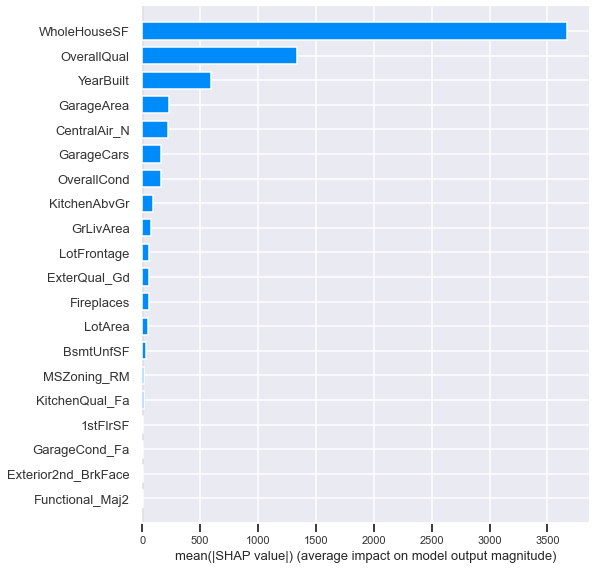

In [47]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [48]:
top_mean_shapley = ["WholeHouseSF","OverallQual","YearBuilt","GarageArea","CentralAir_N","GarageCars","OverallCond","KitchenAbvGr","GrLivArea","LotFrontage","ExterQual_Gd","Fireplaces","LotArea","BsmtUnfSF","MSZoning_RM","KitchenQual_Fa","1stFlrSF","GarageCond_Fa","Exterior2nd_BrkFace","Functional_Maj2"]

## Starting the modelling part

In [49]:
assert homeprices_train_dummy_features.shape[1] == homeprices_test_dummy_features.shape[1], \
"They don't have same number of columns."

## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [50]:
# GBM grid search

monotone_constraints={"SalePrice":1}

best_gbm = model.gbm_grid(X_labels, y_label, train_h2o, valid_h2o, SEED, monotone_constraints_ = monotone_constraints)


print(best_gbm.coef)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_Key_Frame__upload_9d91d06ab2eb359bba773b0130034e4a.hex_model_python_1593121946497_1_model_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,42.000,42.000,27791.000,9.000,13.000,12.095,20.000,59.000,47.619




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 275627693.9925088
RMSE: 16602.038850469806
MAE: 7846.431575648238
RMSLE: 0.0755591257724488
Mean Residual Deviance: 275627693.9925088

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 995485214.0510185
RMSE: 31551.31081351484
MAE: 16738.40820783797
RMSLE: 0.1310494655139242
Mean Residual Deviance: 995485214.0510185

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-06-25 17:52:44,0.061 sec,0.000,78100.936,57075.610,6099756209.182,82402.901,58012.791,6790238139.214
1,,2020-06-25 17:52:44,0.298 sec,1.000,71830.025,52033.193,5159552516.372,75894.443,52805.029,5759966455.874
2,,2020-06-25 17:52:44,0.354 sec,2.000,66048.839,47480.340,4362449067.289,70056.288,48200.000,4907883424.710
3,,2020-06-25 17:52:44,0.387 sec,3.000,60964.548,43487.123,3716676146.047,64669.929,44204.834,4182199738.470
4,,2020-06-25 17:52:44,0.425 sec,4.000,55962.104,39646.737,3131757103.133,59744.850,40376.869,3569447045.034
5,,2020-06-25 17:52:44,0.463 sec,5.000,51806.328,36306.052,2683895644.421,55699.886,37213.300,3102477279.262
6,,2020-06-25 17:52:44,0.490 sec,6.000,48346.797,33365.913,2337412827.731,52517.328,34483.574,2758069697.162
7,,2020-06-25 17:52:44,0.516 sec,7.000,44849.057,30511.293,2011437890.472,49285.148,31960.500,2429025768.920
8,,2020-06-25 17:52:44,0.540 sec,8.000,42039.522,28189.700,1767321443.628,46914.328,29865.278,2200954196.314
9,,2020-06-25 17:52:44,0.573 sec,9.000,39319.920,25946.514,1546056107.589,44498.278,27892.393,1980096788.401



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,OverallQual,10524285730816.000,1.000,0.384
1,WholeHouseSF,6987411095552.000,0.664,0.255
2,GarageArea,1970987204608.000,0.187,0.072
3,GrLivArea,1210259472384.000,0.115,0.044
4,GarageCars,815859433472.000,0.078,0.030
5,YearRemodAdd,579981082624.000,0.055,0.021
6,BsmtFinSF1,470241837056.000,0.045,0.017
7,LotArea,305480957952.000,0.029,0.011
8,TotalBsmtSF,291068608512.000,0.028,0.011
9,YearBuilt,246581936128.000,0.023,0.009



See the whole table with table.as_data_frame()
<bound method ModelBase.coef of >


In [51]:
# GLM grid search

best_glm = model.glm_grid(X_labels, y_label, train_h2o, valid_h2o, SEED)


print(best_glm.coef)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_9d91d06ab2eb359bba773b0130034e4a.hex_model_python_1593121946497_2_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.99, lambda = 640.25 )","nlambda = 100, lambda.max = 64025.0, lambda.min = 640.25, lambda.1...",293,255,100,Key_Frame__upload_9d91d06ab2eb359bba773b0130034e4a.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1410964310.3302562
RMSE: 37562.80487836679
MAE: 23611.288871846125
RMSLE: 0.17901608497631363
R^2: 0.7686851306932189
Mean Residual Deviance: 1410964310.3302562
Null degrees of freedom: 1021
Residual degrees of freedom: 766
Null deviance: 6233950845784.427
Residual deviance: 1442005525157.522
AIC: 24945.335440227453

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 1988597502.0138783
RMSE: 44593.6935228949
MAE: 24614.0449629062
RMSLE: 0.17698131526147395
R^2: 0.7070849890876014
Mean Residual Deviance: 1988597502.0138783
Null degrees of freedom: 437
Residual degrees of freedom: 182
Null deviance: 2974124304975.7227
Residual deviance: 871005705882.0787
AIC: 11134.874764095364

Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-06-25 17:52:59,0.000 sec,1,.64E5,1,6099756209.182,6790238139.214
1,,2020-06-25 17:52:59,0.005 sec,2,.61E5,3,6099018580.830,6789412168.452
2,,2020-06-25 17:52:59,0.010 sec,3,.58E5,3,6097812367.484,6788048538.871
3,,2020-06-25 17:52:59,0.014 sec,4,.56E5,4,6096252268.553,6786315507.445
4,,2020-06-25 17:52:59,0.018 sec,5,.53E5,4,6094386268.731,6784262134.295
5,,2020-06-25 17:52:59,0.022 sec,6,.51E5,6,6092272940.069,6781945048.491
6,,2020-06-25 17:52:59,0.025 sec,7,.48E5,7,6089117219.005,6778513505.756
7,,2020-06-25 17:52:59,0.029 sec,8,.46E5,8,6085154382.427,6774142850.763
8,,2020-06-25 17:52:59,0.032 sec,9,.44E5,10,6080553424.712,6769065909.620
9,,2020-06-25 17:52:59,0.036 sec,10,.42E5,11,6075149428.789,6763120155.975



See the whole table with table.as_data_frame()
<bound method ModelBase.coef of >


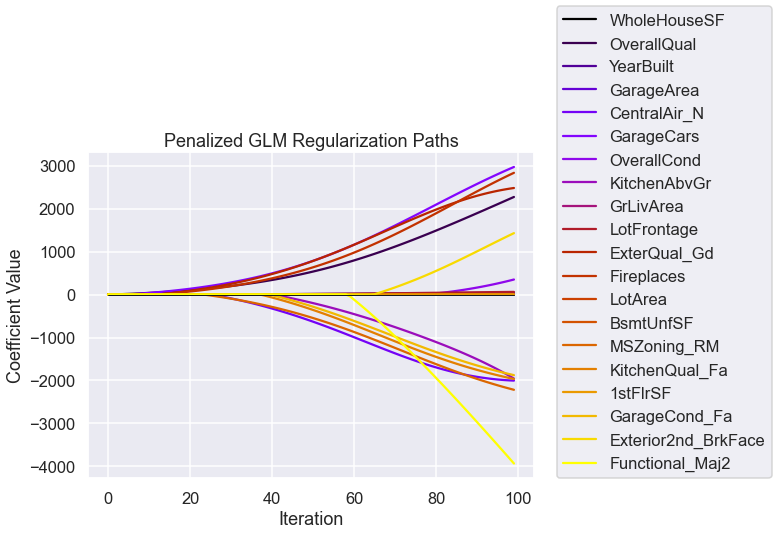

In [52]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

    
# establish benchmark feature selection: glm_selected 
# glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)

glm_selected = top_mean_shapley
# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

In [53]:
# init dict to hold partial dependence and ICE values
# for each feature
# for glm
glm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in glm_selected: 
    glm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_glm)

In [54]:
glm_pd_ice_dict

{'WholeHouseSF':     WholeHouseSF  partial_dependence
 0        882.000          173980.193
 1       1452.675          176459.696
 2       2023.350          178939.199
 3       2594.025          181418.701
 4       3164.700          183898.204
 5       3735.375          186377.706
 6       4306.050          188857.209
 7       4876.725          191336.712
 8       5447.400          193816.214
 9       6018.075          196295.717
 10      6588.750          198775.219
 11      7159.425          201254.722
 12      7730.100          203734.224
 13      8300.775          206213.727
 14      8871.450          208693.230
 15      9442.125          211172.732
 16     10012.800          213652.235
 17     10583.475          216131.737
 18     11154.150          218611.240
 19     11724.825          221090.743,
 'OverallQual':     OverallQual  partial_dependence
 0         3.000          174106.991
 1         3.367          174940.634
 2         3.734          175774.276
 3         4.101      

In [52]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=20, seed=SEED)

In [53]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)

aml.train(x=X_labels, y=y_label, training_frame=homeprices_train_dummy_h2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)


17:56:50.606: AutoML: XGBoost is not available; skipping it.



model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200625_175650,7.53403e+08,27448.2,7.53403e+08,15084.2,0.127478
StackedEnsemble_AllModels_AutoML_20200625_175650,7.75787e+08,27853,7.75787e+08,14892.4,0.125987
GBM_grid__1_AutoML_20200625_175650_model_4,7.82446e+08,27972.2,7.82446e+08,16192.6,0.133309
GBM_grid__1_AutoML_20200625_175650_model_3,7.90987e+08,28124.5,7.90987e+08,15834,0.13278
GBM_grid__1_AutoML_20200625_175650_model_1,8.17263e+08,28587.8,8.17263e+08,15896.3,0.133962
GBM_4_AutoML_20200625_175650,8.40645e+08,28993.9,8.40645e+08,16140.7,0.134815
GBM_3_AutoML_20200625_175650,8.59036e+08,29309.3,8.59036e+08,16351.2,0.13558
GBM_2_AutoML_20200625_175650,8.76416e+08,29604.3,8.76416e+08,16389.3,0.136391
GBM_1_AutoML_20200625_175650,8.78322e+08,29636.5,8.78322e+08,15639.6,0.133793
DRF_1_AutoML_20200625_175650,8.84057e+08,29733.1,8.84057e+08,16894,0.14241


In [54]:
preds = aml.leader.predict(h2o.H2OFrame(homeprices_test_dummy_features))

In [59]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20200625_175650

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 211213476.38390347
RMSE: 14533.185348845705
MAE: 8050.252049924569
RMSLE: 0.07884881070023668
R^2: 0.9665101384760934
Mean Residual Deviance: 211213476.38390347
Null degrees of freedom: 1459
Residual degrees of freedom: 1456
Null deviance: 9207911334609.979
Residual deviance: 308371675520.4991
AIC: 32139.135194896684

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 753402901.5781689
RMSE: 27448.18576114219
MAE: 15084.230675327459
RMSLE: 0.12747764036151205
R^2: 0.8805409613177255
Mean Residual Deviance: 753402901.5781689
Null degrees of freedom: 1459
Residual degrees of freedom: 1456
Null deviance: 9221193424403.615
Residual deviance: 1099968236304.1265
AIC: 33995.86214556621


In [55]:
predictions = preds.as_data_frame(use_pandas=True)

In [56]:
result = pd.concat([test_ID, predictions], axis=1, sort=False)

In [57]:
result.rename({"predict":"SalePrice"}, axis="columns", inplace=True)

In [58]:
result.to_csv("Abhi_sub.csv", index=False)

### Building surrogate model to explain our stackedensemble model.